Correlation Clustering
====


In [80]:
%load_ext autoreload
%autoreload 2
import os
import scipy.io as sio
import scipy
import pylab as plt
import numpy as np
%matplotlib inline
from corr_cluster import Peak,BetaLike,CorrCluster
front_part = 'STD1_Maya_Berg150312'
# front_part = 'std1_Beth20512'
matfile = front_part + '.corr.mat'
csvfile = front_part + '.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
from corr_cluster import BetaLike,CorrCluster
bl = BetaLike(10,1,1,1,0.01,0.99)
print matfile
cc = CorrCluster(bl,csvfile,matfile,greedy_thresh=0.9)

STD1_Maya_Berg150312.corr.mat
Loaded 6319 peaks
Reading shape correlations from STD1_Maya_Berg150312.corr.mat
Greedy clustering done, resulting in 2641 clusters


In [82]:
front_part = 'std1_Eileen02512'
matfile = front_part + '.corr.mat'
csvfile = front_part + '.csv'
cc2 = CorrCluster(bl,csvfile,matfile,greedy_thresh=0.9)

Loaded 4986 peaks
Reading shape correlations from std1_Eileen02512.corr.mat
Greedy clustering done, resulting in 3484 clusters


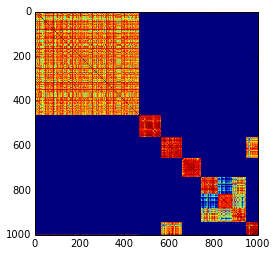

In [83]:
ordered_peaks,order = cc.get_peaks_by_cluster()
cxd = cc.cx.todense()
cxd = cxd[order,:]
cxd = cxd[:,order]
plt.imshow(cxd[:1000,:1000])

Load the database

In [84]:
PROTON = 1.00727645199076


class Mol(object):
    def __init__(self,name,formula,mass,rt):
        self.name = name.strip()
        self.formula = formula.strip()
        self.mass = mass
        self.rt = rt
    def __str__(self):
        return self.name
    def __repr__(self):
        return self.name
mols = []
combined_file = '../../MS2LDA/notebooks/results/StandardsCombined_20150422_forJoe.csv'
print combined_file
with open(combined_file,'rU') as f:
    heads = f.readline()
    for line in f:
        split_line = line.split(',')
        if int(split_line[0])==1:
            new_mol = Mol(split_line[1],split_line[2],float(split_line[4])-PROTON,float(split_line[5]))
            mols.append(new_mol)


../../MS2LDA/notebooks/results/StandardsCombined_20150422_forJoe.csv


In [85]:
def get_hits(mols,ccobj):
    mol_hits = {}
    tol = 5
    for mol in mols:
        mol_hits[mol] = []
        for p in ccobj.peaks:
            if 1e6*np.abs((p.mass - (mol.mass + PROTON))/p.mass) < tol:
    #             if np.abs(p.rt - 60.0*mol.rt) < 100:
                mol_hits[mol].append(p)


    # pick just the most intense
    single_hits = {}
    for mol in mol_hits:
        if len(mol_hits[mol]) == 1:
            single_hits[mol] = mol_hits[mol][0]
        elif len(mol_hits[mol]) > 1:
            max_int = 0
            max_p = None
            for p in mol_hits[mol]:
                if p.intensity > max_int:
                    max_p = p
                    max_int = p.intensity
            single_hits[mol] = max_p
    return single_hits


removed Imidazole-4-acetate because of bad rt match
removed Glycine because of bad rt match


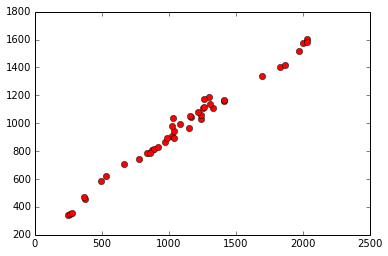

In [118]:
hits1 = get_hits(mols,cc)
hits2 = get_hits(mols,cc2)
x = []
y = []
for mol in mols:
    if mol in hits1 and mol in hits2:
        if np.abs(hits1[mol].rt - hits2[mol].rt) > 500:
            hits1.pop(mol)
            hits2.pop(mol)
            print "removed {} because of bad rt match".format(mol)
        else:
            x.append(hits1[mol].rt)
            y.append(hits2[mol].rt)
plt.figure()
plt.plot(x,y,'ro')

Cytidine
1414.15002441 1160.4699707


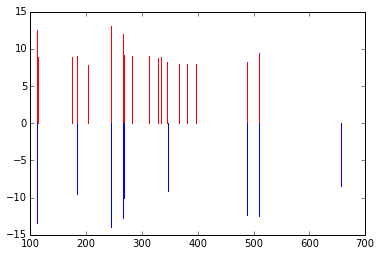

In [109]:
mol = mols[20]
print mol
if mol in hits1:
    if mol in hits2:
        print hits1[mol].rt,hits2[mol].rt
        plt.figure()
        cl1 = cc.Z[hits1[mol]]
        cl2 = cc2.Z[hits2[mol]]
        for p in cl1.members:
            plt.plot([p.mass,p.mass],[0,np.log(p.intensity)],'r')
        for p in cl2.members:
            plt.plot([p.mass,p.mass],[0,-np.log(p.intensity)],'b')
            

Use glutamine as an example

In [ ]:
import transformation
transformations = transformation.load_from_file('pos_transformations.yml')

hits = {}
for mol in mols:
    # match against the clusters
    mol_peaks = [t.reversetransform(mol.mass) for t in transformations]
    for cluster in cc.clusters:
        hits = 0
        for peak in cluster.members:
            for mp in mol_peaks:
                if 1e6*np.abs(mp - peak.mass)/mp < tol:
                     hits += 1
        if hits >= 1:
            nhits[cluster] = hits
    print nhits

In [ ]:
l = [t.transform(peaks[0]) for t in transformations]
print l
m = [a.reversetransform(b) for a,b in zip(transformations,l)]
print m
print peaks[0].mass

In [ ]:
import plotly
print plotly.__version__            # version 1.9.x required
plotly.offline.init_notebook_mode() # run at the start of every notebook
import plotly.graph_objs as go



In [ ]:
def plot_ms(peaks):
    plt.figure()
    x = []
    y = []
    roundx = []
    for p in peaks:
        x.append(p.mass)
        roundx.append(np.round(p.mass,decimals=1))
        y.append(p.intensity)
    data = [
        go.Bar(
        x = roundx,
        y = y,
       dx = 100,
        )
            ]
    layout = go.Layout(
            title = 'Peaks',
            annotations = [
                dict(
                x = xi,
                y = yi,
                text = str(xi),
                showarrow = False,
                xanchor='center',
                yanchor='bottom',
            )for xi,yi in zip(x,y) if yi>1e6]
    )
    fig = go.Figure(data=data,layout=layout)
    plotly.offline.iplot(fig)
    

In [ ]:
plot_ms(cc.greedy_clusters[0].members)

In [ ]:
import plotly.graph_objs as go

c = []
for i in range(1000):
    t = []
    for j in range(1000):
        t.append(cxd[i,j])
    c.append(t);

data = [
    go.Heatmap(
        z=c,
    )]
plotly.offline.iplot(data)